In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pyaldata
import h5py

from numpy.fft import fft, fftfreq

# %load_ext lab_black

Matplotlib created a temporary cache directory at /tmp/matplotlib-caqanxcd because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:

# just going to hard code this obviously change this if the data changes
experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat",  # the best!
    # "Chewie_CO_VR_2016-09-09.mat",
    # "Chewie_CO_VR_2016-09-12.mat",
    # "Chewie_CO_VR_2016-09-14.mat",
    # "Chewie_CO_VR_2016-10-06.mat",
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
    # "Mihili_CO_VR_2014-03-03.mat",
    # "Mihili_CO_VR_2014-03-04.mat",
    # "Mihili_CO_VR_2014-03-06.mat",
]


# Helpers (mainly plotting)

In [3]:
def plot_neuron_n_info(n, spike_data, AD_start, WO_start, vel, time_ticks, sort_trials, area, before_align_point=100):
    """
    This shouldnt be a helper tbh but needed to plot many neurons so now here we are
    n : neuron id to plot (relative to spike data) 
    spike_data : aligned spikes
    AD_start : idx of row in df with first AD trial
    WO_start : idx of row in df with first WO tria 
    vel : hand velocity (aligned as with spike data) 
    time_ticks : used throughout for plotting
    sort_trials : 
    area : name of region (M1/PMd/all) used for plot title
    before_align_point=100 : first part of window size
    """

    # n = 27 # [14, 27, 29, 35, 50, 58, 61, 64, 66, 69]
    #sort_trials = np.argsort(target_on)

    fig = plt.figure(figsize=(5, 10))
    ax1 = fig.add_subplot(311)

    kernel = np.exp(-np.linspace(-3,3,20)**2)
    kernel /= kernel.sum()

    for e,fr in zip(['BL',"AD",'WO'],[spike_data[:AD_start].mean(0),spike_data[AD_start:WO_start].mean(0),spike_data[WO_start:].mean(0)]):
        fr_s = np.asarray([np.convolve(np.concatenate([fr[::-1,i],fr[:,i],fr[::-1,i]]), kernel, mode='same')[fr.shape[0]:-fr.shape[0]] for i in range(fr.shape[1])]).T
        plt.plot(fr_s[:,n],label=f'avg. fr in {e}')

    for e,c,v in zip(['BL','AD','W0'],['C0','C1','C2'],[vel[:AD_start].mean(0),vel[AD_start:WO_start].mean(0),vel[WO_start:].mean(0)]):
        plt.plot(-v[:,0]/50,c=c,linestyle="--",label=f'avg. vel X in {e}')

    plt.axvline(before_align_point, color='red', linestyle='-', label='peak speed')
    plt.legend(loc='upper left')
    plt.title(f'Firing rate of {area} neuron #{n}, avg. per epoch')
    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.xlabel('time (ms)')
    plt.ylabel('neuron #')


    fig.add_subplot(312,sharex=ax1)
    plt.axvline(before_align_point, color='red', linestyle='-', label='go cue')

    # plt.scatter(before_align_point - target_on[sort_trials], np.arange(len(target_on)), color='red', label='target on',marker='|')
    plt.imshow(spike_data[sort_trials,:,n], aspect='auto', cmap='gray_r',interpolation='none')
    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.title(f'Example {area} neuron #{n}')
    plt.xlabel('time (ms)')
    plt.ylabel('trial #')

    plt.axhline(AD_start, color='blue', linestyle='-', label='AD')
    plt.axhline(WO_start, color='blue', linestyle='-', label='WO')

    fig.add_subplot(313,sharex=ax1)
    plt.axvline(before_align_point, color='red', linestyle='-', label='go cue')

    plt.imshow(vel[...,0],aspect='auto', cmap='gray',interpolation='none')
    plt.axhline(AD_start, color='blue', linestyle='-', label='AD')
    plt.axhline(WO_start, color='blue', linestyle='-', label='WO')

    plt.xticks(time_ticks, (time_ticks - before_align_point) * 10)
    plt.title(f'Velocity X')
    plt.xlabel('time (ms)')
    plt.ylabel('trial #')

    plt.tight_layout(h_pad=1)

# Set paths

In [4]:
raw_data_dir = (
    "/disk/scratch2/nkudryas/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

# Set parameters

In [157]:
spike_data_dir = experiments[5] # which experiment from list above do you want to load

"""
activity_key : which neurons to load {"PMd_spikes", "M1_spikes", "all_spikes"}
behaviour_key : behaviour to train to (sometimes assumed to be velocity)
full_behaviour_key : the other behaviour (vel or pos). Here often assumed to be position
alignment : align trials to this point in the experinment. {"go"}
"""
activity_key = "all_spikes" #"PMd_spikes" # "all_spikes" #"M1_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation
full_behaviour_key = "pos"  # extra variable used for validation

"""
perc_train : percentage of trials to use for training
perc_valid/test : percentage of trials to use for valid/test sets. In some code if perc_test==0 then test set will be equivalent to valid set (stops lfads complaining)
"""
perc_train = 80
perc_valid = 20
perc_test = 0

"""
start_key : point to align trials to
shortest_trial : length of trials once aligned (in bins, 10ms assumed)
before_align_point : time to keep before alignment point (in bins, 10ms assumed)
"""
start_key = 'idx_movement_on'#'idx_peak_speed' # 
trial_len = 120 

"""
dataset_type : keep all epochs? session is all epochs, can also do BLAD (only baseline and adaptation trials)
"""
dataset_type = "session"

longest_trial = None # dont know

ablation_study=True
oscillation_threshold = 0.6 # doesnt matter (except plotting) unless ablation_study==True

"""
dt : time step size - this actually depends on the bin window but I cant find where this is set - it is 10ms rn
"""
dt = 0.01


# Summarize velocity oscillations

In [91]:
# select rows where no value in the velocity array exceed 100
# in pd_data
pd_data['vel'].apply(lambda x: np.all(np.abs(x) < 100))

0      True
1      True
2      True
3      True
4      True
       ... 
832    True
833    True
834    True
835    True
836    True
Name: vel, Length: 837, dtype: bool

In [158]:
# load all velocities for all sessions
vel, epoch = {}, {}
idx_go_cue, idx_movement_on, idx_peak_speed, idx_trial_end = {}, {}, {}, {}
for spike_data_dir in experiments:
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir + spike_data_dir, shift_idx_fields=True
    )

    # trials must be successful to be included
    selected_trials = pd_data.loc[
            (pd_data.result == "R") & (pd_data['vel'].apply(lambda x: np.all(np.abs(x) < 100)))
        ]

    # shortest_trial = int(
    #         (selected_trials.idx_trial_end - selected_trials[start_key]).min()
    #     ) 
    
    vel[spike_data_dir] = np.asarray(
            [
                d[f'vel'][d.idx_trial_end - trial_len : d.idx_trial_end, :]
                for _, d in selected_trials.iterrows()
            ]
        )
    
    # epoch (BL/AD/WO) for each trial
    epoch[spike_data_dir] = np.asarray(
            [
                d['epoch']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    idx_go_cue[spike_data_dir] = np.asarray(
            [
                d['idx_go_cue']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_movement_on[spike_data_dir] = np.asarray(
            [
                d['idx_movement_on']
                for _, d in selected_trials.iterrows()
            ]
    )

    idx_peak_speed[spike_data_dir] = np.asarray(
            [
                d['idx_peak_speed']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_trial_end[spike_data_dir] = np.asarray(
            [
                d['idx_trial_end']
                for _, d in selected_trials.iterrows()
            ]
    )


        

/disk/scratch2/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:953: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


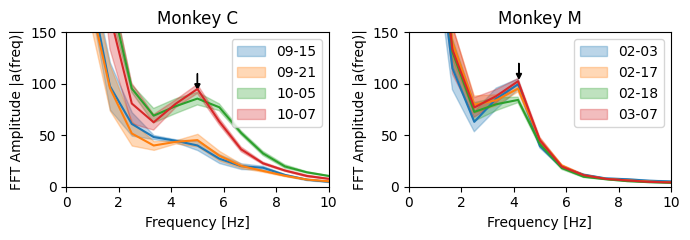

In [108]:

fig, axes = plt.subplots(1,2,figsize=(7,2.5))

for ax, m, exps in zip(axes, ['C','M'],[experiments[:4],experiments[4:]]):
    for i,spike_data_dir in enumerate(exps):

        # trial types are ordered in df
        AD_start = np.where(epoch[spike_data_dir]=='AD')[0][0]
        WO_start = np.where(epoch[spike_data_dir]=='WO')[0][0]

        V = vel[spike_data_dir][AD_start:WO_start, :] # get data for AD trials, time point 80 onwards
        # plt.imshow(V[...,0])
        # plt.show()
        # if spike_data_dir == experiments[0]:
            # V = np.concatenate((V[:85],V[86:])) # discard a trial with enormous velocity
        T = dt * V.shape[1]
        # print(V.shape[1])

        SR = []
        for cv in range(100):

            idxs = np.random.choice(V.shape[0], V.shape[0], replace=True)
            for c in [0,1]:

                x = V[idxs][...,c]

                xf = fft(x)  # Compute Fourier transform of x
                Sxx_all = np.sqrt((xf * xf.conj()).real) #2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum

                Sxx = np.mean(Sxx_all, axis=0)  # trial average per epoch

                df = 1 / T  # Determine frequency resolution
                fNQ = 1 / dt / 2  # Determine Nyquist frequency
                faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

                SR.append(Sxx)

        SR = np.asarray(SR)
        # j = np.argmin(np.abs(faxis-5))
        # print(SR[:,j])

        mask = (faxis > 0) & (faxis <= 10)
        ax.plot(
            faxis[mask],
            SR.mean(0)[mask],c=f'C{i}')
        
        ax.fill_between(
            faxis[mask],
            SR.mean(0)[mask] - SR.std(0)[mask],
            SR.mean(0)[mask] + SR.std(0)[mask],
            alpha=0.3, color=f'C{i}', label=spike_data_dir.split('_')[3].split('.mat')[0][5:]
        )

    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('FFT Amplitude |a(freq)|')
    ax.set_title(f'Monkey {m}')
    ax.set_ylim([0,150])
    ax.set_xlim([0,10])
    ax.legend()


axes[0].arrow(5., 110, 0, -10, color="k", head_width=.2, head_length=5)
axes[1].arrow(4.2, 120, 0, -10, color="k", head_width=.2, head_length=5)

plt.tight_layout()
fig.savefig('./figs/fft_velocity.svg')

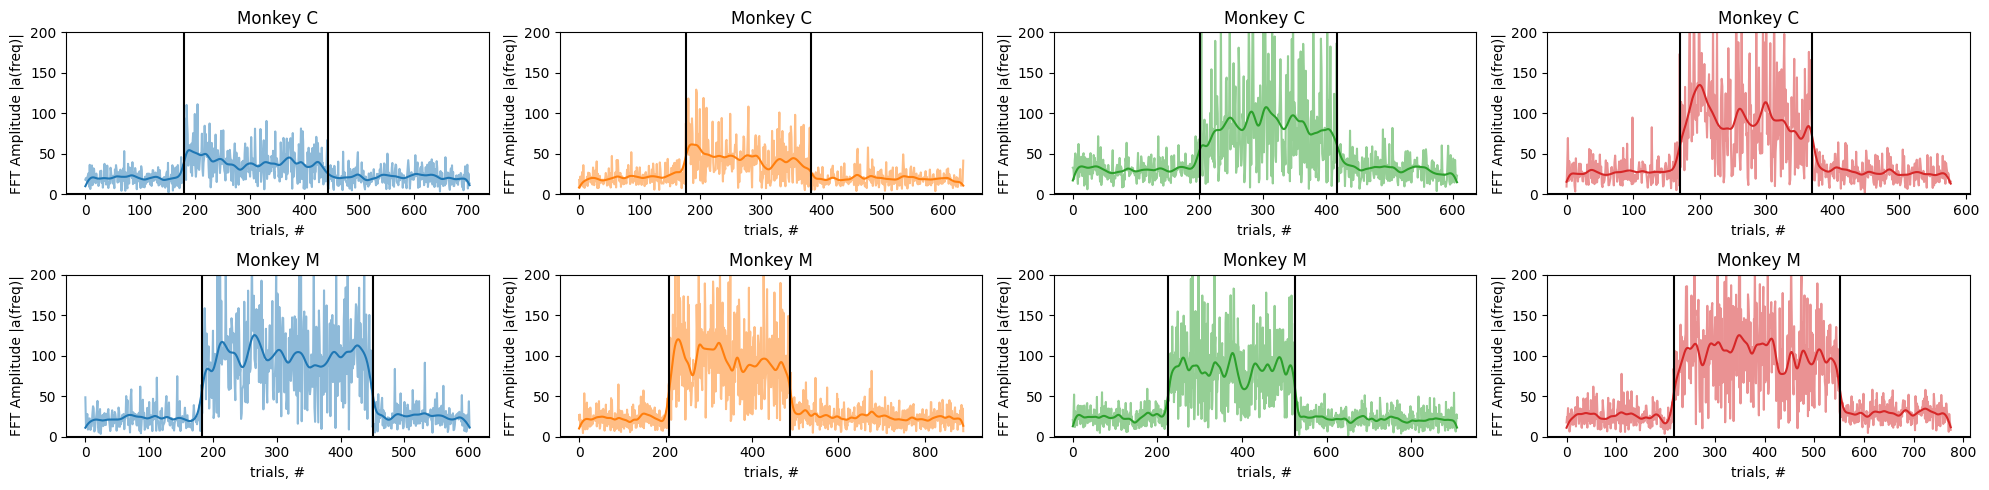

In [177]:

fig, axes = plt.subplots(2,4,figsize=(20,5))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4.2])):
    for i,spike_data_dir in enumerate(exps):

        # trial types are ordered in df
        AD_start = np.where(epoch[spike_data_dir]=='AD')[0][0]
        WO_start = np.where(epoch[spike_data_dir]=='WO')[0][0]

        V = vel[spike_data_dir][:, :] # get data for all trials, time point 80 onwards
        T = dt * V.shape[1]
        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(V.shape[1]) / dt  # Construct frequency axis
        find_4Hz = np.argmin(np.abs(faxis-peak_fr))
        
        SR = []
        for c in [0,1]:
            x = V[...,c]
            xf = fft(x)  # Compute Fourier transform of x
            # Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum, trials x frequences

            SR.append(np.sqrt((xf*xf.conj()).real)[:,find_4Hz])

        SR = np.asarray(SR) # components, trials

        trials = np.arange(SR.shape[1])
        axes[j,i].plot(
            trials,
            SR.mean(0),c=f'C{i}',alpha=0.5)
        # gaussian filter
        kernel = np.exp(-np.linspace(-3,3,50)**2)
        kernel /= kernel.sum()
        axes[j,i].plot(
            trials,
            np.convolve(SR.mean(0), kernel, mode='same'),c=f'C{i}',label='smoothed'
        )

        axes[j,i].set_xlabel('trials, #')
        axes[j,i].set_ylabel('FFT Amplitude |a(freq)|')
        axes[j,i].set_title(f'Monkey {m}')
        axes[j,i].set_ylim(0,200)
        axes[j,i].axvline(AD_start,c='k')
        axes[j,i].axvline(WO_start,c='k')
        axes[j,i].axhline(0,c='k')
        # ax.legend()

plt.tight_layout()
fig.savefig('./figs/fft_velocity.svg')

0.9999999999999998
1.0
1.0
1.0
1.0
1.0
1.0000000000000002
1.0
1.0
1.0000000000000002
1.0
0.9999999999999997
1.0
1.0
1.0000000000000004
1.0000000000000002


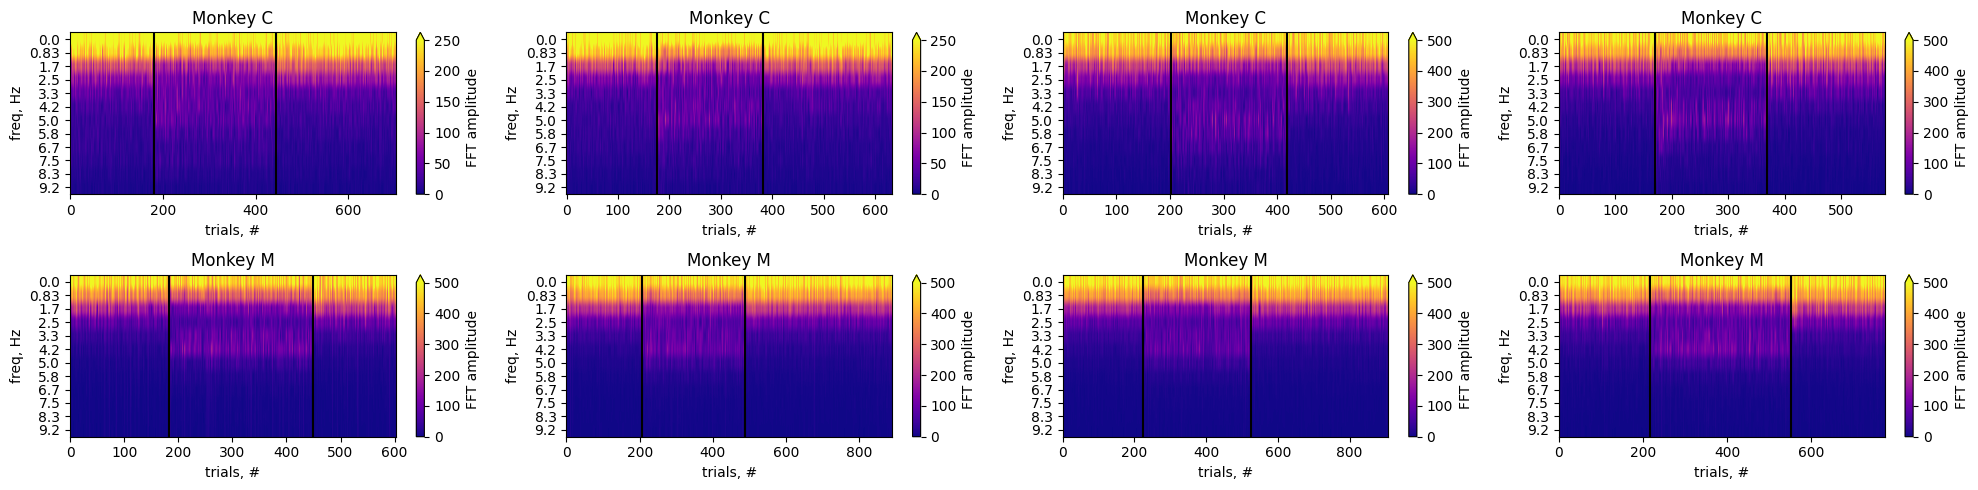

In [184]:

fig, axes = plt.subplots(2,4,figsize=(20,5))

for j, (m, exps) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]])):
    for i,spike_data_dir in enumerate(exps):

        # trial types are ordered in df
        AD_start = np.where(epoch[spike_data_dir]=='AD')[0][0]
        WO_start = np.where(epoch[spike_data_dir]=='WO')[0][0]

        V = vel[spike_data_dir][:, :] # get data for all trials, time point 80 onwards
        T = dt * V.shape[1]
        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(V.shape[1]) / dt  # Construct frequency axis
            
        SR = []
        for c in [0,1]:
            x = V[...,c]
            xf = fft(x)  # Compute Fourier transform of x
            # Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum, trials x frequences

            print(np.sum((xf*xf.conj()).real)/np.sum(x**2)*dt/T)

            SR.append(np.sqrt((xf*xf.conj()).real))

        SR = np.asarray(SR) # components, trials, frequencies

        mask = (faxis>=0.) & (faxis<10.)
        vmax = 250 if (j==0) & (i<2) else 500
        im = axes[j,i].imshow(SR.mean(0).T[mask],aspect='auto',cmap='plasma',vmin=0, vmax=vmax)
        plt.colorbar(im, ax=axes[j,i], extend='max', label='FFT amplitude')

        axes[j,i].set_xlabel('trials, #')
        axes[j,i].set_ylabel('freq, Hz')
        axes[j,i].set_yticks(np.arange(len(faxis[mask])))
        axes[j,i].set_yticklabels([f"{s:.2}" for s in faxis[mask]])
        axes[j,i].set_title(f'Monkey {m}')
        axes[j,i].axvline(AD_start,c='k')
        axes[j,i].axvline(WO_start,c='k')

plt.tight_layout()
fig.savefig('./figs/fft_velocity.svg')

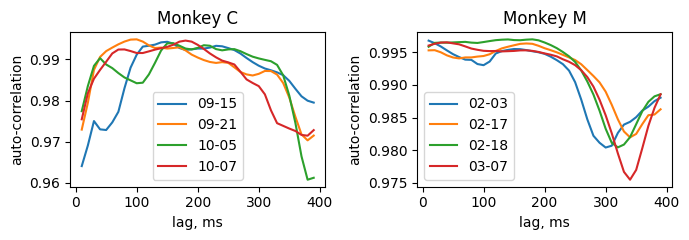

In [113]:

fig, axes = plt.subplots(1,2,figsize=(7,2.5))

lags = np.arange(1,40,1)

for ax, m, exps in zip(axes, ['C','M'],[experiments[:4],experiments[4:]]):
    for i,spike_data_dir in enumerate(exps):

        # trial types are ordered in df
        AD_start = np.where(epoch[spike_data_dir]=='AD')[0][0]
        WO_start = np.where(epoch[spike_data_dir]=='WO')[0][0]

        V = vel[spike_data_dir][AD_start:WO_start, :] # get data for AD trials, time point 80 onwards
        x = np.sqrt(V[...,0]**2 + V[...,1]**2).T

        corr = []
        for lag in lags:
            corr.append(np.corrcoef(x[lag:-40],x[:-40+lag])[0,1])

        ax.plot(10*lags,corr,c=f'C{i}',label=spike_data_dir.split('_')[3].split('.mat')[0][5:])

    ax.set_xlabel('lag, ms')
    ax.set_ylabel('auto-correlation')
    ax.set_title(f'Monkey {m}')
    # ax.set_ylim([0.0,4])
    # ax.set_xlim([0,10])
    ax.legend()


# axes[0].arrow(4.5, 2.8, 0, -.5, head_width=0.25, color="k")
# axes[1].arrow(3.5, 3.8, 0, -.5, head_width=0.25, color="k")

plt.tight_layout()

Check reaction time of Chewie vs Mihili

Chewie_CO_FF_2016-09-15.mat 231.74964438122333
Chewie_CO_FF_2016-09-21.mat 247.41324921135646
Chewie_CO_FF_2016-10-05.mat 241.26644736842107
Chewie_CO_FF_2016-10-07.mat 246.98961937716263
Mihili_CO_FF_2014-02-03.mat 283.167495854063
Mihili_CO_FF_2014-02-17.mat 253.4606741573034
Mihili_CO_FF_2014-02-18.mat 263.6303630363036
Mihili_CO_FF_2014-03-07.mat 241.72680412371133


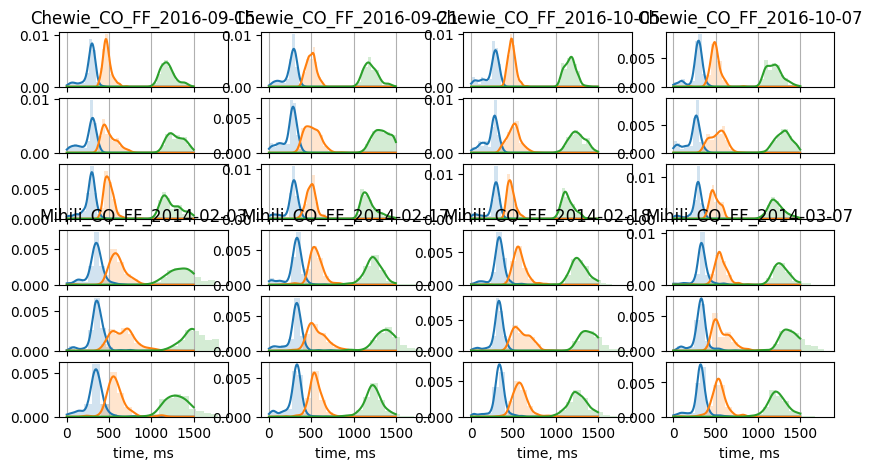

In [163]:
from scipy import stats

fig, axes = plt.subplots(2*3,4,figsize=(10,5),sharex=True)
for i, (m, exps) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]])):

    for j, exp in enumerate(exps):
        for k, e in enumerate(['BL','AD','WO']):

            ax = axes[i*3 + k,j]
            dels = 10*(idx_movement_on[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C0',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C0')

            dels = 10*(idx_peak_speed[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C1',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C1')

            dels = 10*(idx_trial_end[exp]-idx_go_cue[exp])[epoch[exp]==e]
            ax.hist(dels, density=True, color='C2',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C2')

            if k == 0:
                ax.set_title(exp.split('.mat')[0])
            if k == 2:
                ax.set_xlabel('time, ms')
            ax.grid(which='major', axis='x', zorder=-1.0)

        print(exp,np.mean(idx_peak_speed[exp]-idx_movement_on[exp])*10)
plt.savefig('time_progress.svg')

# Load spikes

In [37]:
spike_data_dir = experiments[3] # which experiment from list above do you want to load

start_key = 'idx_peak_speed' # 

# load data
pd_data = pyaldata.io.mat2dataframe(
    path=raw_data_dir + spike_data_dir, shift_idx_fields=True
)



In [38]:

if activity_key == "all_spikes":
    pd_data[activity_key] = [
        np.concatenate([m1, pmd], axis=1)
        for m1, pmd in zip(pd_data["M1_spikes"], pd_data["PMd_spikes"])
    ]
    print(
        pd_data["M1_spikes"][0].shape,
        pd_data["PMd_spikes"][0].shape,
        pd_data["all_spikes"][0].shape,
    )

# trials must be successful to be included
selected_trials = pd_data.loc[
        (pd_data.result == "R") #& (pd_data.epoch == "AD")
    ]

# epoch (BL/AD/WO) for each trial
epoch = np.asarray(
        [
            d['epoch']
            for i, d in selected_trials.iterrows()
        ]
    )
# trial types are ordered in df
AD_start = np.where(epoch=='AD')[0][0]
WO_start = np.where(epoch=='WO')[0][0]

shortest_trial = int(
        (selected_trials.idx_trial_end - selected_trials[start_key]).min()
    )
print(start_key,shortest_trial)

num_m1_units = pd_data["M1_spikes"][0].shape[1]

# sanity check train/valid/test settings
assert perc_train + perc_valid + perc_test == 100

# needed for plots, must align with chosen region
activity_key_to_area = {"PMd_spikes" : "PMd", "M1_spikes" : "M1", "all_spikes" : "all"}
area = activity_key_to_area[activity_key] # 'M1' #'PMd' # 'all' # 'M1'

# spike data from area, aligned to start key such that with window [- before_align_point : start_key : + shortest trial ]
spike_data = np.asarray(
        [
            d[f'{area}_spikes'][d[start_key] - before_align_point : d[start_key] + shortest_trial, :]
            for i, d in selected_trials.iterrows()
        ]
    )
print(spike_data.shape)
# time between start key and go cue
target_on = np.asarray(
        [
            d[start_key] - d['idx_go_cue']
            for i, d in selected_trials.iterrows()
        ]
    )

# useful for plotting
time_ticks = np.arange(spike_data.shape[1])[::25]
sort_trials = np.arange(len(target_on))

(359, 70) (359, 137) (359, 207)
idx_peak_speed 47
(581, 147, 207)


In [39]:
def spike_2_fr(spike_data, dt=0.01):
    FR = np.zeros_like(spike_data,dtype='float')
    kernel = np.exp(-np.linspace(-3,3,18)**2)
    kernel /= np.sum(kernel)
    for t in range(spike_data.shape[0]):
        for n in range(spike_data.shape[2]):
            spikes = spike_data[t,:,n]
            FR[t,:,n] = np.convolve(spikes, kernel, mode='same') * (1/dt)
    return FR

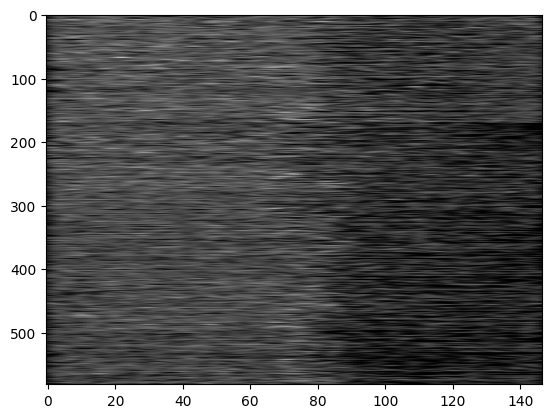

In [40]:
n = 17
plt.imshow(spike_2_fr(spike_data[:,:,n:n+1]),aspect='auto',cmap='gray') #,interpolation='none')

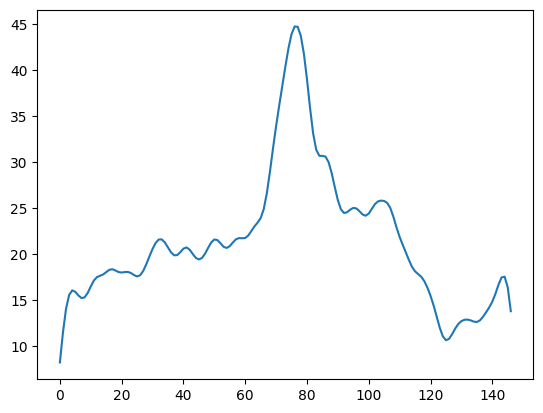

In [41]:
plt.plot(spike_2_fr(spike_data[:AD_start,:,[2,]]).mean(0))

# 1, 27,	28,	35,	69,	132,	144,	157,	

In [42]:
spike_data.shape # 581 total trials, 155 time points (before_align_point + shortest_trial), 207 neurons for full set

(581, 147, 207)

In [43]:
FR = np.zeros_like(spike_data,dtype='float')
kernel = np.exp(-np.linspace(-3,3,12)**2)
kernel /= np.sum(kernel)
# plt.plot(kernel)
for t in range(spike_data.shape[0]):
    for n in range(spike_data.shape[2]):
        # spikes = np.zeros(FR.shape[1])
        spikes = spike_data[t,:,n]
        FR[t,:,n] = np.convolve(spikes, kernel, mode='same')

In [44]:

# power5_shuffled = []
# for _ in range(10):
#     shuffled_spikes = np.zeros_like(spike_data)
#     for t in range(spike_data.shape[0]):
#         for n in range(spike_data.shape[2]):
#             shuffled_spikes[t,:,n] = np.random.permutation(spike_data[t,:,n])

#     fr = shuffled_spikes[AD_start:WO_start, time_window_start:] # get data for AD trials, time point 80 onwards
#     T = dt * fr.shape[1]

#     power5 = []
#     for i in range(fr.shape[-1]): # for each neuron
#         x = fr[:, :, i] # get the AD spike data for neuron i

#         xf = fft(x)  # Compute Fourier transform of x
#         Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum
#         Sxx = np.nanmean(Sxx, axis=0)  # trial average per epoch

#         df = 1 / T  # Determine frequency resolution
#         fNQ = 1 / dt / 2  # Determine Nyquist frequency
#         faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

#         j = np.argmin(np.abs(faxis - 5))
#         power5.append(Sxx.real[j]) # power at 5Hz

#     power5_shuffled.append(power5)
# power5_shuffled = np.asarray(power5_shuffled)

In [45]:
faxis[j]

3.4482758620689653

In [46]:

plt.figure(figsize=(3.5,2))

fr = spike_data[AD_start:WO_start, time_window_start:] # get data for AD trials, time point 80 onwards
T = dt * fr.shape[1]

power5 = []
for i in range(fr.shape[-1]): # for each neuron
    # if i==0:
    x = fr[:, :, i] # get the AD spike data for neuron i

    xf = fft(x)  # Compute Fourier transform of x
    Sxx_all = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum

    power5_cv = []
    for cv in range(10):
        idxs = np.random.choice(np.arange(Sxx_all.shape[0]),int(0.8*Sxx_all.shape[0]),replace=False)
        Sxx = np.nanmean(Sxx_all[idxs], axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = np.argmin(np.abs(faxis - 5))
        power5_cv.append(Sxx.real[j])

    power5.append(np.mean(power5_cv)) # power at 5Hz

    SR = Sxx.real

    if (activity_key=="all_spikes") and (i>pd_data["M1_spikes"][0].shape[1]):
        # only plot if m1
        thr = power5_shuffled[:,i].mean() + 4 * power5_shuffled[:,i].std()
        if power5[-1]>=thr:
            print(i)
        plt.plot(
            faxis[(faxis > 0) & (faxis <= 10)],
            SR[(faxis > 0) & (faxis <= 10)],c='k' if power5[-1]<thr else 'C1',alpha=0.3)
    
plt.xlabel('Frequency [Hz]')
plt.ylabel('FFT Amplitude |v(freq)|')
plt.title(f'Fourier spectrum of {area} neurons')
plt.ylim([0.0,0.01])

NameError: name 'power5_shuffled' is not defined

<Figure size 350x200 with 0 Axes>

---

# Create two sets - subsampling neurons according to oscillating/non-oscillating.

In [ ]:
# identify neurons which are oscillating based on the power5 array

print(oscillation_threshold)
# n_m1 = 70 # number of m1 neurons in the set we are only going to care about m1 neurons oscillating
# n_total = 207

total_neurons = len(power5)
oscillating_criteria = np.where(np.array(power5)>oscillation_threshold)[0]
oscillating_neurons = [x for x in oscillating_criteria if x<=num_m1_units] # idx for oscillating neurons
# non_oscillating_neurons = np.where(np.array(power5)<=oscillation_threshold)[0] # since there are nans caused by the fourier transform, just take anything not flagged as oscillating
non_oscillating_neurons = [x for x in np.arange(0,207) if (x not in oscillating_neurons)]
if ablation_study:


    # calculate number of train and test neurons
    # neurons_per_set = total_neurons - len(oscillating_neurons) # subsample neurons based on number of oscillating neurons


    # oscillation_control set contains neurons which oscillate
    # randomly subset neurons_per_set
    # np.random.seed(38) # dont change this
    # poss_array = sorted(np.random.choice(np.arange(0,70), neurons_per_set, replace=False))
    # # sneaky check that we kept all the oscillating neurons
    # len([x for x in poss_array if x in oscillating_neurons])==10

    # oscillation_ablation set contain neurons which do not oscillate

    neurons_to_keep = non_oscillating_neurons # dont ablate these
    print(oscillating_neurons)
    print(len(oscillating_neurons))
    # len(neurons_to_keep)
else:
    neurons_to_keep = np.arange(0, len(power5))


0.6
[]
0


# check tuning of oscillating neurons

In [ ]:

# aligned spike data - excludes neurons if ablation_study=True
all_spike_data = np.asarray(
        [
            d[activity_key][d[start_key] : d[start_key] + shortest_trial, neurons_to_keep]
            for i, d in successful_trials.iterrows()
        ]
    )
print(all_spike_data.shape)

# target directions for each trial
target_directions = np.asarray([d["target_direction"] for i, d in successful_trials.iterrows()])
print(target_directions.shape)
# as above but index
set_directions = sorted(set(target_directions))
dir_index = np.array([set_directions.index(i) for i in target_directions])
print(len(dir_index))


NameError: name 'successful_trials' is not defined

In [ ]:
shortest_trial
# all_spike_data.shape[1]

47

In [ ]:


trials_by_direction_dict = {i:all_spike_data[list(np.where(dir_index==i)[0]),:,:] for i in np.unique(dir_index)}
trial_inds_by_direction_dict = {i: np.where(dir_index==i)[0] for i in np.unique(dir_index)}


NameError: name 'dir_index' is not defined

In [ ]:
# fr = spike_data[:AD_start, 100:]

def get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start):

    pow5_dict = {}
    for dir_ind, trial_inds in trial_inds_by_direction_dict.items():
        trial_inds_AD = [tr for tr in trial_inds if tr>=AD_start and tr<WO_start] # get adaptation trials for condition
        fr = spike_data[trial_inds_AD, 80:, neuron] # get data for AD trials, time point 80 onwards
        # print(fr.shape)

        T = dt * fr.shape[1]

        # power5 = []
        # for i in range(fr.shape[-1]): # for each neuron
        # if i==0:
        x = fr # get the AD spike data for neuron i

        # x = (x - x.mean(0)) / x.std(0) # z score by mean over trials for each timepoint

        xf = fft(x)  # Compute Fourier transform of x
        Sxx = 2 * dt**2 / T * (xf * xf.conj())  # Compute spectrum
        Sxx = np.nanmean(Sxx, axis=0)  # trial average per epoch

        df = 1 / T  # Determine frequency resolution
        fNQ = 1 / dt / 2  # Determine Nyquist frequency
        faxis = fftfreq(len(Sxx)) / dt  # Construct frequency axis

        j = 4 # timepoint of interest...?
        # print(faxis[j],Sxx.real[j])
        # print(Sxx.real[j-1], Sxx.real[j], Sxx.real[j+1])
        pow_entry = (Sxx.real[j]/(Sxx.real[j-1]+Sxx.real[j+1]))
        if np.isnan(pow_entry):
            pow_entry = 0
        pow5_dict[dir_ind] = pow_entry # power at 5Hz

        # SR = Sxx.real
        # SR[SR>0.05] = 0.05
    return pow5_dict

In [ ]:
get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, 1, AD_start, WO_start)

NameError: name 'trial_inds_by_direction_dict' is not defined

In [ ]:
# this_trial_type = trials_by_direction_dict[0]
# neuron = 0

def plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions):
    # dict of {cond_index : power} pairs

    avg_activity_by_cond = []
    max_activity_by_cond = []

    for i, trials_for_dir in trials_by_direction_dict.items():
        trials_for_neuron = trials_for_dir[:,:before_align_point,neuron]
        avg_across_trials = np.nanmean(trials_for_neuron, axis=0) ##

        # average and max avg activity across trials of this type
        avg_across_time = avg_across_trials.mean()
        # print(avg_across_time)
        avg_activity_by_cond.append(avg_across_time)

        max_across_time = avg_across_trials.max()
        # print(max_across_time)
        max_activity_by_cond.append(max_across_time)

        # xax = np.arange(0, avg_across_trials.shape[0])
        # plt.plot(xax, avg_across_trials)

    pow5_by_cond = list(pow5_dict.values()) 

    # for i, dir in enumerate(set_directions):
    #     print(dir, avg_activity_by_cond[i], pow5_by_cond[i])

    fig, ax = plt.subplots(1,1, figsize=(5,5))

    ax.plot(set_directions, avg_activity_by_cond, label='avg activity')
    ax.plot(set_directions, pow5_by_cond, label='power at 5Hz')

    ax.set_xlabel('Condition direction')
    ax.set_xticks(set_directions)
    ax.set_ylabel('Power at 5Hz within condition')
    ax.set_title(f'by condition, neuron {neuron}')
    ax.legend(loc='upper left')
    # ax[0].set_ylim([0.0,0.05])

    


In [ ]:
# neuron = 0

for neuron in oscillating_neurons:
    pow5_dict = get_pow5_for_conds(spike_data, trial_inds_by_direction_dict, neuron, AD_start, WO_start)
    plot_tuning_for_neuron(neuron, pow5_dict, trials_by_direction_dict, set_directions)